# Twitter analysis of climate change perceptions

In [158]:
# Import libraries
import config
import pandas as pd
import numpy as np
import itertools
import collections
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
pd.set_option('display.max_colwidth', -1)

# Text processing tools
import tweepy
from textblob import TextBlob, Word
import re, nltk, gensim, spacy
from nltk.corpus import stopwords
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Visualization libraries
from geopy.geocoders import Nominatim
import gmplot
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


sns.set(font_scale=1.5)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /home/ivana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
# Interacting with twitter's API
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret) 
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API (auth, wait_on_rate_limit = True) 

In [132]:
# Clean the tweets
def clean_tweet(tweet):
    """ Utility function to clean a tweet by removing 
    links and special characters using regex.

    Parameters
    ----------
    tweet : string
        A text string that you want to parse and remove special characters.

    Returns
    -------
    The same tweet string without special characters removed.
    """
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())   

In [133]:
# List of tweets related to climate change
search_words = ("#ClimateChange", "Environment", "climate", "climatechange", "environment")


def get_tweets_df(search_words):
    """Extracts tweets, finds sentiment score and returns tweets as a DataFrame 

    Parameters
    ----------
    search_words : list 
        A list of phrases to extract
    
    Returns
    -------
    Pandas DataFrame of tweets
    """
    res = []
    # Extract tweets for a given list of phrases
    for word in search_words:
        for tweet in tweepy.Cursor (api.search, 
                                    q = word + " -filter:retweets", 
                                    lang = "en").items(150):
            res.append(tweet)
   
    id_list = [tweet.id for tweet  in res]
    
    # Create tweets DataFrame
    data_set = pd.DataFrame(id_list, columns = ["id"])
    data_set["text"] = [tweet.text for tweet in res]
    data_set["len"]  = np.array([len(tweet.text) for tweet in res])
    data_set["created_at"] = [tweet.created_at for tweet in res]
    data_set["user_location"] = [tweet.author.location for tweet in res]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in res]
    
    # Use clean function to remove special characters
    data_set["text"] = np.array([ clean_tweet(tweet) for tweet in data_set['text'] ])
    
    # Add Sentiment score and class
    text = data_set["text"]
    for i in range(0,len(text)):
        textB = TextBlob(text[i])
        sentiment = textB.sentiment.polarity

        data_set.at[i, 'sentiment'] = sentiment
        if sentiment <0.00:
            SentimentClass = 'Negative'
            data_set.at[i, 'sentiment_class'] = SentimentClass 
        elif sentiment >0.00:
            SentimentClass = 'Positive'
            data_set.at[i, 'sentiment_class']= SentimentClass 
        else:
            SentimentClass = 'Neutral'
            data_set.at[i, 'sentiment_class']= SentimentClass
    
    return data_set
    

In [134]:
# Create tweets DataFrame
tweets_df = get_tweets_df(search_words)
tweets_df.head()

,id,text,len,created_at,user_location,Hashtags,sentiment,sentiment_class
0,1181120940115189760,melanie extinction rebellion starts at north ClimateChange xx,102,2019-10-07 08:15:50,"North West, England","[{'text': 'ClimateChange', 'indices': [85, 99]}]",0.000000,Neutral
1,1181120727279386624,Long term plan needed to respond to climate change Vietnam ClimateChange ClimateAction,115,2019-10-07 08:15:00,Vietnam,"[{'text': 'Vietnam', 'indices': [77, 85]}, {'text': 'ClimateChange', 'indices': [86, 100]}, {'text': 'ClimateAction', 'indices': [101, 115]}]",-0.050000,Negative
2,1181120628662964225,The cognitive dissonance and sheer stupidity of today s online Dail Mail is as sad as it is unsurprising,129,2019-10-07 08:14:36,,[],-0.366667,Negative
3,1181120530579165184,Texas North Dakota And New Mexico Leading the U S Shale Oil Revolution via,134,2019-10-07 08:14:13,"Madrid, España",[],0.136364,Positive
4,1181120511843209216,How are banks doing on sustainable finance commitments Not good enough energy sustainability climatechange,134,2019-10-07 08:14:08,UK,"[{'text': 'energy', 'indices': [96, 103]}, {'text': 'sustainability', 'indices': [104, 119]}, {'text': 'climatechange', 'indices': [120, 134]}]",-0.175000,Negative


### Text clean up
To preprocess the tweets we will need to replace capital letters with lower case, remove stopwords and transform words to their base form.


In [135]:
# Create a list of lists containing lowercase words for each tweet
lower_tweets = [tweet.lower().split() for tweet in tweets_df.text] 
lower_tweets[:2]

[['melanie',
  'extinction',
  'rebellion',
  'starts',
  'at',
  'north',
  'climatechange',
  'xx'],
 ['long',
  'term',
  'plan',
  'needed',
  'to',
  'respond',
  'to',
  'climate',
  'change',
  'vietnam',
  'climatechange',
  'climateaction']]

In [136]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in lower_tweets]
tweets_nsw[:2]

[['melanie',
  'extinction',
  'rebellion',
  'starts',
  'north',
  'climatechange',
  'xx'],
 ['long',
  'term',
  'plan',
  'needed',
  'respond',
  'climate',
  'change',
  'vietnam',
  'climatechange',
  'climateaction']]

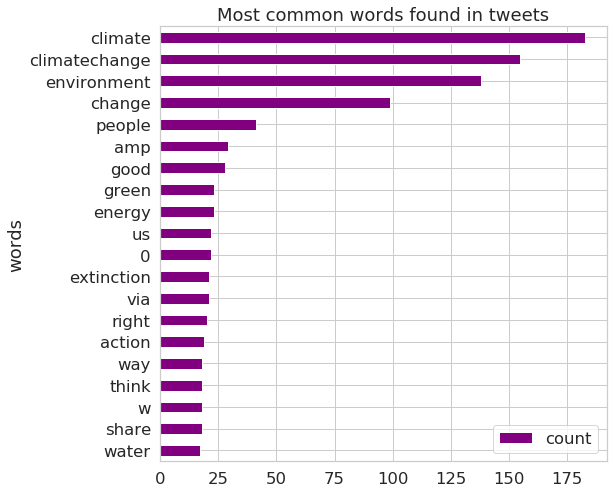

In [137]:
# Flatten list of words in clean tweets
all_words_nsw = list(itertools.chain(*tweets_nsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets")
plt.show()

In addition to removal of stopwords, we will also create a collection of our own topic related words. Since we have  used "climated change" as a collection term, this term appear in every collected tweet. Therefore, we can expect that these terms will dominate the list of the most frequent words. In order to obtain new insight into the perceptions of twitter users we remove the search words from tweets through list comprehension.

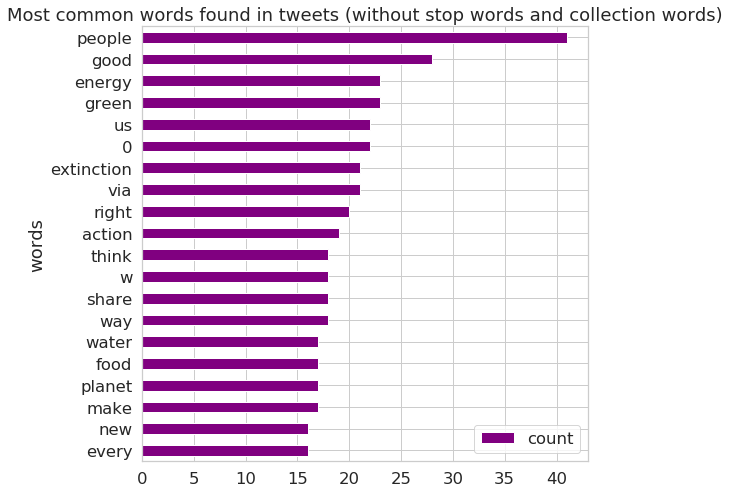

In [138]:
# Create a list of words to remove
remove_words = ("#ClimateChange", "Environment", "climate", "climatechange", "change", "amp", "much", "environment")

# Remove search words and rerun word frequency plot
tweets_nsw_rsw = [[w for w in word if not w in remove_words]
                  for word in tweets_nsw]

# Flatten list of words in clean tweets
all_words_nsw_rsw = list(itertools.chain(*tweets_nsw_rsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw_rsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets (without stop words and collection words)")
plt.show()

In next section I will explore the co-occuring words (bigrams) in the tweets. Analysis of bigrams provides deeper understanding compared to single words.

In [139]:
# Create a list of lists containing bigrams in tweets
tweet_bigrams = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_rsw]

# Display bigrams from the first tweet
tweet_bigrams[0]

[('melanie', 'extinction'),
 ('extinction', 'rebellion'),
 ('rebellion', 'starts'),
 ('starts', 'north'),
 ('north', 'xx')]

In [140]:
# Display the original tweet 
tweets_df.text[0]

'melanie extinction rebellion starts at north ClimateChange xx'

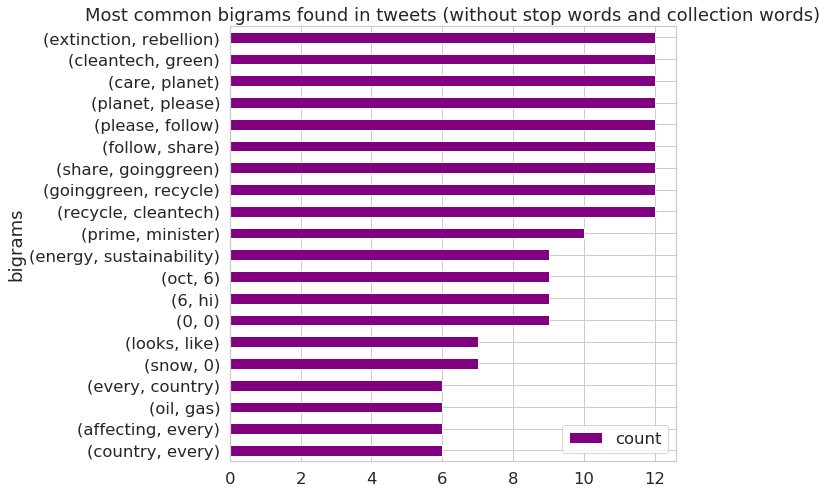

In [141]:
# Flatten list of bigrams
bigrams = list(itertools.chain(*tweet_bigrams))

# Create a counter of most frequent bigrams
bigrams_count = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigrams_count.most_common(20),
                         columns=['bigrams', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
bigram_df.sort_values(by='count').plot.barh(x='bigrams',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common bigrams found in tweets (without stop words and collection words)")
plt.show()

### Geospatial analysis
Next we will look at where are people tweeting from.

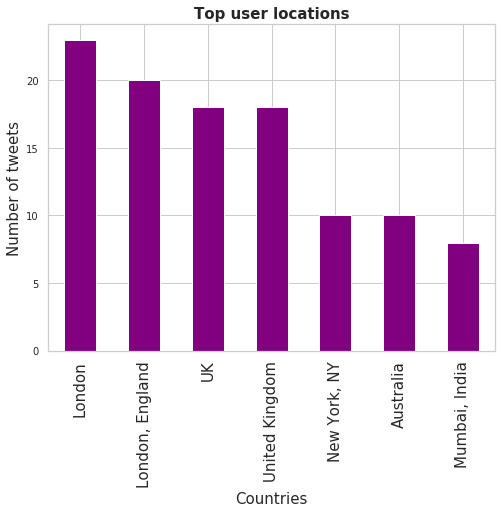

In [142]:
# Plot horizontal bar graph to see where majority of tweets are from
tweets_by_country = tweets_df['user_location'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top user locations',fontsize=15, fontweight='bold')
tweets_by_country[1:8].plot(ax=ax, kind='bar', color='purple')

To get better sense of where the majority of tweets are coming from we will use the user locations in text format such as "London, England" and transform it into latitude and longitude coordinates. Having the coordinates we can create a heatmap visualization.

In [26]:
# Plot user locations on heatmap
geoloc = Nominatim()


# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}  

for count, user_loc in enumerate(tweets_df.user_location):  
    try:
        location = geoloc.geocode(user_loc)
        

        # If coordinates are found for location append them and wait so the TimeOut Error is not raised
        if location:
            coordinates['latitude'].append(location.latitude)
            coordinates['longitude'].append(location.longitude)
            time.sleep(0.5)

    # If too many connection requests
    except:
        pass

# Instantiate and center a GoogleMapPlotter object to show our map
gmap = gmplot.GoogleMapPlotter(30, 0, 3)

# Insert points on the map passing a list of latitudes and longitudes
gmap.heatmap(coordinates['latitude'], coordinates['longitude'], radius=20)

# Save the map to html file
gmap.draw("vis/tweets_heatmap.html")

### Sentiment analysis
Sentiment analysis or otherwise known as opinion mining, looks at the emotional tone behind a series of words, used to gain an understanding of the the attitudes, opinions and emotions expressed within a text. Sentiment analysis is extremely useful in social media monitoring as it allows us to gain an overview of the wider public opinion behind the analysed topic. 

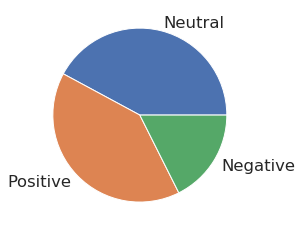

In [143]:
# Plot pie chart of sentiment classes
tweets_sentiment = tweets_df['sentiment_class'].value_counts()

# Create a pie chart
plt.pie(tweets_sentiment, labels=tweets_sentiment.index)
plt.show()

In [144]:
# Print descriptive statistics
tweets_df.sentiment.describe()

count    750.000000
mean     0.074982  
std      0.240123  
min     -1.000000  
25%      0.000000  
50%      0.000000  
75%      0.175000  
max      1.000000  
Name: sentiment, dtype: float64

In [145]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmax()]

'spoke on ClimateChange and how businesses can use best practices to protect and preserve the environment b'

In [146]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmin()]

'If we stop polluting with CO2 the WORST that can happen is a healthier world so everyone take that risk of bein'

### Topic modeling
Topic Modeling is a form of unsupervised learning used for identifying common “topics” in large clusters of texts.
Topics can be defined as a repeating pattern of co-occurring terms in a corpus.

To compare the agruments used by twitter users we will look at how the topics differ for positive and negative tweets. 

In [147]:
# Create a column of tweets excluding stopwords
tweets_df['clean_text']=tweets_nsw

# Create a list of positive and negative tweets
positive_tweets = tweets_df.clean_text.loc[tweets_df['sentiment'] >= 0.3]
negative_tweets = tweets_df.clean_text.loc[tweets_df['sentiment'] <= -0.]

In [156]:
# Define a function which will lemmatize words. This will transfrom words to its base form
def lemmatization(tweets_nsw , allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """ Lemmetize tweets  

    Parameters
    ----------
    tweets_nsw : list 
        A list of tweets excluding stop words
    
    Returns
    -------
    List of lemmetized tweets
    """
    texts_out = []
    for tweet in tweets_nsw:
        doc = nlp(" ".join(tweet)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
positive_tweets_lemmatized = lemmatization(positive_tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
negative_tweets_lemmatized = lemmatization(negative_tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


print(negative_tweets_lemmatized[:2])

['melanie extinction rebellion start north climatechange', 'long term plan need respond climate change vietnam climatechange climateaction']


In [155]:
# Tokenize each sentence into a list of words
def tweets_to_words(tweets):
    """ Tokenize tweets  

    Parameters
    ----------
    tweets : list 
        A list of tweets to tokenize
    
    Returns
    -------
    List of tokenized tweets
    """
    for sentence in tweets:
        yield(gensim.utils.simple_preprocess(str(sentence)))  

positive_tweets_words = list(tweets_to_words(positive_tweets_lemmatized))
negative_tweets_words = list(tweets_to_words(negative_tweets_lemmatized))


print(negative_tweets_words[:2])

[['melanie', 'extinction', 'rebellion', 'start', 'north', 'climatechange'], ['long', 'term', 'plan', 'need', 'respond', 'climate', 'change', 'vietnam', 'climatechange', 'climateaction']]


In [160]:
# Create Dictionaries
pos_id2word = corpora.Dictionary(positive_tweets_words)
neg_id2word = corpora.Dictionary(negative_tweets_words)

# Term Document Frequency
pos_corpus = [pos_id2word.doc2bow(text) for text in positive_tweets_words]
neg_corpus = [neg_id2word.doc2bow(text) for text in negative_tweets_words]


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(0, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [162]:
# Build LDA models
pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=pos_corpus,
                                           id2word=pos_id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=neg_corpus,
                                           id2word=neg_id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [165]:
# Visualize the positive topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(pos_lda_model, pos_corpus, pos_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.046860 -0.135678  1       1        45.150959
1     -0.159317  0.032748  2       1        30.840618
0      0.112456  0.102930  3       1        24.008421, topic_info=    Category       Freq           Term      Total  loglift  logprob
217  Default  16.000000  learn          16.000000  30.0000  30.0000
61   Default  8.000000   great          8.000000   29.0000  29.0000
270  Default  6.000000   main           6.000000   28.0000  28.0000
272  Default  5.000000   motivator      5.000000   27.0000  27.0000
269  Default  5.000000   always         5.000000   26.0000  26.0000
..       ...       ...      ...              ...       ...      ...
6    Topic3   0.825921   country        3.162882   0.0840  -5.5364 
78   Topic3   0.825906   people         2.563214   0.2942  -5.5364 
0    Topic3   0.825904   climatechange  8.915844  -0.9523  -5.5364 
175  Topic3   0.825901   think          1.963658   0.5607  -5.5365 
19   Topic3   0.825900   today          4.054040  -0.1642  -5.5365 

[150 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
67    2      0.441752  activist 
67    3      0.441752  activist 
246   1      0.945690  adjust   
263   2      0.861390  aldgate  
269   3      0.840113  always   
...  ..           ...      ...  
5     2      0.513706  wildwater
73    3      0.504857  wonder   
237   1      0.598205  word     
105   1      0.598205  work     
180   3      0.594977  zephaniah

[132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [166]:
# Visualize the negative topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(neg_lda_model, neg_corpus, neg_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.164765  0.064899  1       1        42.010670
2     -0.018399 -0.157790  2       1        33.967197
0     -0.146366  0.092892  3       1        24.022135, topic_info=    Category       Freq           Term      Total  loglift  logprob
226  Default  87.000000  environment    87.000000  30.0000  30.0000
157  Default  14.000000  green          14.000000  29.0000  29.0000
158  Default  12.000000  planet         12.000000  28.0000  28.0000
7    Default  77.000000  climate        77.000000  27.0000  27.0000
142  Default  9.000000   share          9.000000   26.0000  26.0000
..       ...       ...     ...               ...       ...      ...
38   Topic3   3.740895   risk           7.049034   0.7926  -5.4418 
0    Topic3   6.248505   climatechange  52.882427 -0.7095  -4.9288 
4    Topic3   3.837403   rebellion      9.165443   0.5556  -5.4163 
465  Topic3   3.740899   bad            8.272621   0.6326  -5.4418 
69   Topic3   3.846499   people         16.114481 -0.0064  -5.4139 

[175 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
329   2      0.926859  activist
200   1      0.315877  air     
200   3      0.631753  air     
765   3      0.927515  akin    
667   3      0.927515  ako     
...  ..           ...   ...    
481   2      0.363237  work    
65    1      0.338504  world   
65    3      0.677008  world   
66    1      0.728790  year    
66    3      0.182197  year    

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])